In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate

# UNITS
ev2au = 1/27.211396132
au2ev = 27.211396132
ang2au = 1/0.529177249
au2ang = 0.529177249
au2fs = 1/41.34137333656
fs2au = 41.34137333656
au2debye = 1/0.39343
debye2au = 0.39343
au2nm = 0.052917720859
nm2au = 1/0.052917720859
au2cm1 = 2.1947463137E5
cm12au = 1/(2.1947463137E5)
au2amu = 1/1822.88848325
amu2au = 1822.88848325
thz2au = 1.0/0.029979/au2cm1

In [2]:

#La suma debe ser una suma de 32 terminos

coeff_matrix = np.zeros((32,4))
coeff_matrix[0,:] = [0,0,1,32849.58]
coeff_matrix[1,:] = [0,1,1,-17553.99]
coeff_matrix[2,:] = [1,0,1,-27625.23]
coeff_matrix[3,:] = [2,0,0,50043.09]
coeff_matrix[4,:] = [4,0,0,336.49]
coeff_matrix[5,:] = [0,1,2,-3360.94]
coeff_matrix[6,:] = [0,3,0,-64.84]
coeff_matrix[7,:] = [1,1,1,18285.40]
coeff_matrix[8,:] = [2,0,1,-7181.44]
coeff_matrix[9,:] = [0,0,4,2553.25]
coeff_matrix[10,:] = [0,2,2,-4905.39]
coeff_matrix[11,:] = [0,4,0,3505.21]
coeff_matrix[12,:] = [1,1,2,-21845.86]
coeff_matrix[13,:] = [1,3,0,-1416.44]
coeff_matrix[14,:] = [2,1,1,5596.86]
coeff_matrix[15,:] = [3,0,1,-142.39]
coeff_matrix[16,:] = [0,0,2,15623.64]
coeff_matrix[17,:] = [0,2,0,72972.84]
coeff_matrix[18,:] = [1,1,0,9857.17]
coeff_matrix[19,:] = [3,0,0,-2376.30]
coeff_matrix[20,:] = [0,2,1,-8550.95]
coeff_matrix[21,:] = [1,0,2,-4597.25]
coeff_matrix[22,:] = [1,2,0,-657.28]
coeff_matrix[23,:] = [2,1,0,1985.36]
coeff_matrix[24,:] = [0,1,3,-5546.12]
coeff_matrix[25,:] = [0,3,1,-11098.50]
coeff_matrix[26,:] = [1,0,3,-9178.03]
coeff_matrix[27,:] = [1,2,1,948.74]
coeff_matrix[28,:] = [2,0,2,-983.04]
coeff_matrix[29,:] = [2,2,0,-584.78]
coeff_matrix[30,:] = [3,1,0,1694.77]
coeff_matrix[31,:] = [0,0,3,4971.79]

def V(R1,R2,theta):
    R1e = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
    R2e = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
    alpha_1 = 1.95/ang2au #Amstrong^-1
    alpha_2 = 2.34/ang2au #Amstrong^-1
    theta_e = np.pi #Degrees

    aR1 = -alpha_1*(R1-R1e)
    aR2 = -alpha_2*(R2-R2e)

    y_1 = 1.0 - np.exp(aR1)
    y_2 = 1.0 - np.exp(aR2)
    y_3 = np.cos(theta) - np.cos(theta_e)

    suma = 0.0
    for i in range(32):
        suma = suma + (coeff_matrix[i,3]*cm12au)*(y_1**int(coeff_matrix[i,0]))*(y_2**int(coeff_matrix[i,1]))*(y_3**(coeff_matrix[i,2]))
    return(suma)

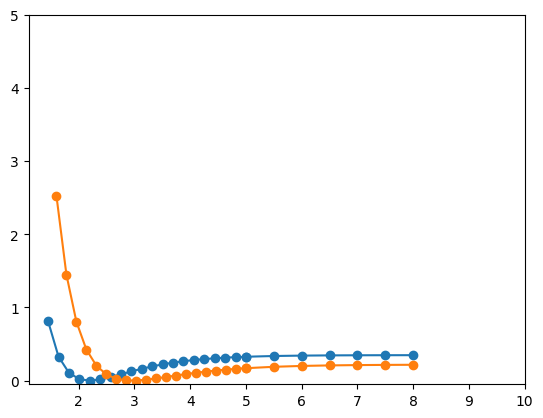

In [3]:
q1 = np.concatenate((np.linspace(1.45,5.0,20),np.linspace(5.0, 8, 7)))
q2 = np.concatenate((np.linspace(1.6,5.0,20),np.linspace(5.0, 8, 7)))
R1_eq = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
R2_eq = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
theta_eq = np.pi
plt.plot(q1, V(R1_eq,q1,theta_eq), "o-")
plt.plot(q2, V(q2,R2_eq,theta_eq), "o-")
plt.axis([1.1,10,-0.05,5])
plt.show()
#Iniciar desde el tercer punto de naranjo. max no varia
#Debe dar un comportamiento como la grafica
#Probar ambos modelos y comparar

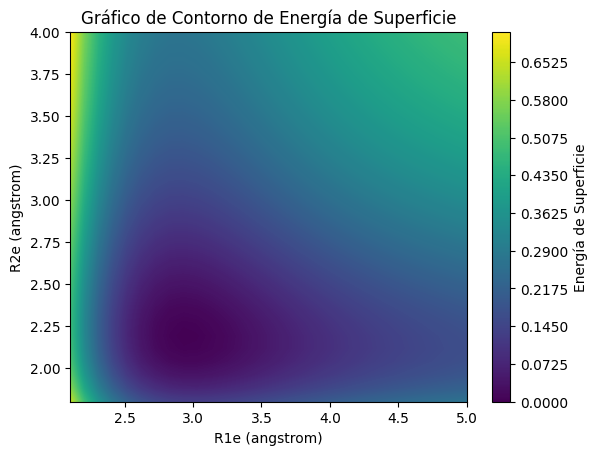

In [4]:
R1e_values = np.linspace(2.1, 5, 29)  # ajusta estos valores según tus necesidades
R2e_values = np.linspace(1.8, 4, 29)  # ajusta estos valores según tus necesidades

R1e, R2e = np.meshgrid(R1e_values, R2e_values)
energia_superficie = np.vectorize(V)(R1e, R2e, np.pi)  # np.vectorize para aplicar la función a matrices

plt.contourf(R1e, R2e, energia_superficie,300)
plt.colorbar(label='Energía de Superficie')

plt.xlabel('R1e (angstrom)')
plt.ylabel('R2e (angstrom)')
plt.title('Gráfico de Contorno de Energía de Superficie')
plt.show()


In [5]:
# Generacion del archivo de datos
data_set = np.zeros((len(q1)**2,3)) #Dim(900,3)
l = 0 #Inicializa en 0
for i in range(len(q1)): #R1
    for j in range(len(q2)): #R2
        data_set[l,:] = q1[i],q2[j],V(q1[i],q2[j],np.pi) #Obtenemos valores para R1, R2 y V(R1,R2)
        l = l + 1

df = pd.DataFrame(data_set)
df.to_csv('PotencialOCS_2.csv')
df.columns = ['R1','R2','V'] #Renombramos las columnas
df

,R1,R2,V
0,1.45,1.600000,4.769169
1,1.45,1.778947,4.379094
2,1.45,1.957895,4.140660
3,1.45,2.136842,3.995638
4,1.45,2.315789,3.909743
...,...,...,...
724,8.00,6.000000,0.607018
725,8.00,6.500000,0.610105
726,8.00,7.000000,0.611772
727,8.00,7.500000,0.612672


In [6]:
inputsmodel = df.drop('V', axis=1)
inputsmodel
#R2 desde 1.6. primer punto del potencial menor a 2.

,R1,R2
0,1.45,1.600000
1,1.45,1.778947
2,1.45,1.957895
3,1.45,2.136842
4,1.45,2.315789
...,...,...
724,8.00,6.000000
725,8.00,6.500000
726,8.00,7.000000
727,8.00,7.500000


In [7]:
target = df.iloc[:,-1]
target

0      4.769169
1      4.379094
2      4.140660
3      3.995638
4      3.909743
         ...   
724    0.607018
725    0.610105
726    0.611772
727    0.612672
728    0.613156
Name: V, Length: 729, dtype: float64

In [8]:
min(target)
print(max(target))

4.769168831074749


In [9]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(inputs, target, test_size=0.3, random_state=2)

In [10]:
#Functional API
import tensorflow as tf
from tensorflow import keras
from keras.models import Model # type: ignore
import keras.optimizers # type: ignore
from keras.layers import Dense, Input # type: ignore
tf.random.set_seed(5)


ep = 1000
pv = 0.2
opt = keras.optimizers.RMSprop(learning_rate=0.003)

#Inputs
inputs = Input(shape=(2,))

#Hidden
hidden1 = Dense(64, activation='relu')(inputs)
hidden2 = Dense(90, activation='relu')(hidden1)
hidden3 = Dense(90, activation='relu')(hidden2)
hidden4 = Dense(90, activation='relu')(hidden3)
hidden5 = Dense(90, activation='relu')(hidden4)
hidden6 = Dense(90, activation='relu')(hidden5)
hidden7 = Dense(64, activation='relu')(hidden6)

#Output
output = Dense(1, activation='linear')(hidden6)

#Model and Compiler
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=opt, loss='mae', metrics=['mape','mse'])

model.fit(inputsmodel, target, epochs=ep, validation_split=pv, batch_size=240)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.8609 - mape: 244.1086 - mse: 1.5289 - val_loss: 0.3529 - val_mape: 86.0008 - val_mse: 0.1361
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5185 - mape: 145.9654 - mse: 0.8347 - val_loss: 0.1650 - val_mape: 32.9489 - val_mse: 0.0330
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4275 - mape: 85.9194 - mse: 0.8012 - val_loss: 0.0890 - val_mape: 26.5041 - val_mse: 0.0146
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4151 - mape: 105.1627 - mse: 0.7554 - val_loss: 0.1436 - val_mape: 30.1060 - val_mse: 0.0245
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4080 - mape: 83.6205 - mse: 0.7924 - val_loss: 0.0829 - val_mape: 21.8565 - val_mse: 0.0092
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3995 - mape: 101.4907 - mse: 0.7216 - val_loss: 0.1682 - val_mape: 33.4094 - val_mse: 0.0344
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3967 - mape: 82.1

In [11]:
#model.evaluate(X_test, Y_test)

In [12]:
y_pred = model.predict(inputsmodel) #Predecimos datos de Potencial en base a los datos de testing
y_pred
print(len(y_pred))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
729


In [13]:
len(inputsmodel)

729

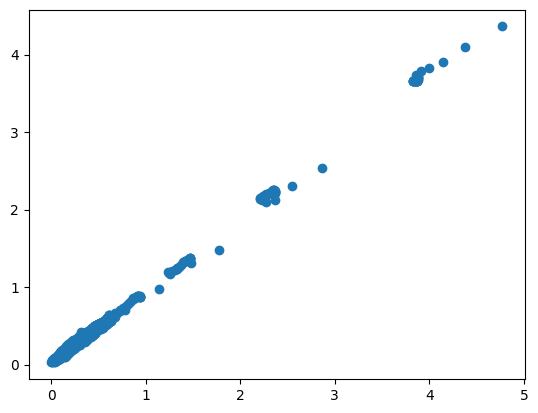

In [14]:
plt.plot(df.V,y_pred,'o')

In [15]:
print(y_pred.shape)
print(df.V.shape)

(729, 1)
(729,)


In [16]:
datos = model.predict_on_batch(inputsmodel) #EStudiar esto
aa= datos.tolist()
lista = []
for i in range(len(aa)):
    lista.append(aa[i][0])
df1 = pd.DataFrame()
df1['predicted'] = lista
df1

,predicted
0,4.361980
1,4.101225
2,3.902873
3,3.820956
4,3.783393
...,...
724,0.620232
725,0.628056
726,0.634224
727,0.639832


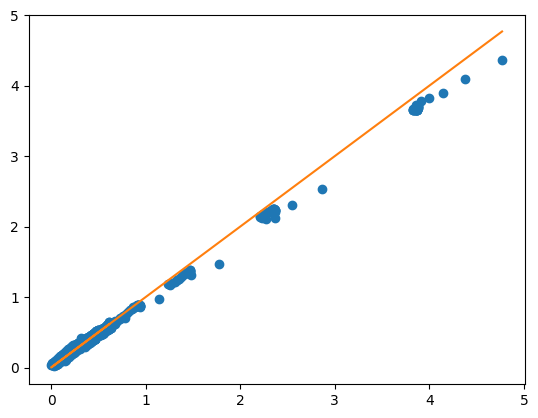

In [17]:
plt.plot(df['V'], df1['predicted'],'o')
plt.plot(df['V'], df['V'])

# Recursos de utilidad
https://wandb.ai/ayush-thakur/dl-question-bank/reports/Input-Keras-Layer-Explanation-With-Code-Samples--VmlldzoyMDIzMDU#:~:text=a%20certain%20way.-,What%20Is%20Dim%20In%20A%20Keras%20Layer%3F,tensor%20like%20(3%2C).



# Creacion de una Physics-Informed Neural Network para el problema de predicciones de moleculas de OCS

- Explicacion de PINNs
- Buscar info de OCS para entender mejor el comportamiento de la molecula
- Explicacion matematica de la funcion loss
- Exp Funcion Morse
- Busqueda del error de energia de la funcion morse
- Incorporacion del error de energia a la loss_fn 
- Modificacion de la NN a PINN 


## To do
- Disociation energy 
- Electronic ground state
- Paper references 6, 23 (DONE)
- J. G Lahaye, R. Vandenhaute. Mol. Spectroc 1995
- P. Jensen, J. Mol, Spectrosc 1998 
- Tabla 2 tiene valores de error observado y $E_{cal}$ (REJECTED)
- Explicar que es la eq de Burger (DONE)

### Obs:
$\textbf{reduce_mean()}$ is used to find mean of elements across dimensions of a tensor.

# Que son las PINNs?
$\textit{Physics Informed neural networks}$ son redes neuronales que incluyen leyes fisicas para resolver un problema fisico, en la forma de ecuaciones diferenciales parciales adicionales al problema supervisado original.
En las PINNs se combinan el efecto de adherirse a una ecuacion fisica asi como tambien los conocimientos familiares de machine learning

## Como se usa una PINN?
Hacer uso de una PINN incluye anadir un residual en terminos de perdida

## Ecuacion de Burgers
Consideramos la ecuacion de Burgers como ejemplo. En una dimension, la ecuacion de Burgers junto con la condicion de frontera de Dirichlet es:

\begin{split}
  u_t + uu_x - (0.001/\pi)u_{xx}=0, \\
  x \in [-1,1],t\in [0,1], \\
  u(0,x)=-\sin(\pi x), \\
  u(t,-1)=u(t,1)=0
\end{split}

Definimos $f(t,x)$ como:
$$f:= u_t+u_x-(0.01/\pi)u_{xx} $$

Luego se aproxima $u(x,t)$ con una red neuronal profunda. Los parametros compartidos entre $u(t,x)$ y $f(t,x)$ se pueden aprender minimizando la perdida de error de minimos cuadrados:

\begin{split}
    MSE=MSE_u+MSE_f, \\
    MSE_u = {1\over{N_u}}\sum_{i=1}^{N_u}{|u(t_{iu},x_{iu})-u_i|^2}, \\
    MSE_f={1\over{N_f}}\sum_{i=1}^{N_f}{|f(t_{if},x_{if})|^2}
\end{split}

el loss $MSE_u$ corresponde al data inial y a las condiciones de frontera iniciales, mientras que $MSE_f$ refuerza la estructura impuesta por la ecuacion de Burgers en un set finito de punto de colocacion, esto actua como un termino residual.
Los puntos t,x junto con la u denotan el training data inicial y de frontera en $u(t,x)$. Los puntos t,x con f especifican los puntos de colocacion para $f(t,x)$

# WORKFLOW
La funcion morse tiene una forma $$D_O[1-\exp^{-\alpha_O(r_O -r_{eq_O})}]^2$$ para el enlace del oxigeno, y una forma $$D_S[1-\exp^{-\alpha_S(r_S -r_{eq_S})}]^2$$ para el enlace del azufre.

La forma de la ecuacion a agregar a la funcion perdida personalizada es del tipo: $$\underbrace{(\hat{y_i}-y_i)^2}_{\text{MSE}} + \underbrace{(\hat{y_i}-V(r_O,r_S))^2}_{\text{PINN MSE}}$$